In [98]:
import os
import librosa
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import wave
import pandas as pd
import pyAudioAnalysis.ShortTermFeatures as sF
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
import warnings

warnings.filterwarnings("ignore")

In [3]:
# Collect all the riffs paths and their labels (band_name)
path_to_raw = 'raw_data'
riff_list = []
label_list = []
for bands, albums, riffs in os.walk(path_to_raw):
    for riff in riffs:
        path_to_riff = os.path.join(bands,riff)
        relative_path = os.path.relpath(path_to_riff, path_to_raw)
        band_name = relative_path.split(os.path.sep)[0]
        riff_list.append(path_to_riff)
        label_list.append(band_name)
assert len(riff_list) == len(label_list)
# Make sure all files are wav files
assert all(riff.endswith('.wav') for riff in riff_list)
print("Total number of riffs collected: ", len(riff_list))
print("Total number of bands collected: ", len(set(label_list)))

Total number of riffs collected:  250
Total number of bands collected:  5


In [4]:
single_path_file = riff_list[5]
print("Example of a single_path_file: ", single_path_file, '\n')

file_path_example = single_path_file
path_components = file_path_example.split(os.sep)

# Extract the relevant information
band = path_components[-3]
album = path_components[-2]
if path_components[-1].endswith('_riff.wav'): song = path_components[-1].replace('_riff.wav','')

print("Band name:", band, '\n')
print("Album:", album, '\n')
print("Song:", song, '\n')

Example of a single_path_file:  raw_data\Dream_Theater\A dramatic turn of events\Outcry_riff.wav 

Band name: Dream_Theater 

Album: A dramatic turn of events 

Song: Outcry 



In [5]:
print(f"Total Dataset contains {len(riff_list)} riffs \n")
print(f"Total Dream_Theater riffs = {label_list.count('Dream_Theater')} \n")
print(f"Total Gojira riffs = {label_list.count('Gojira')} \n") 
print(f"Total Mastodon riffs = {label_list.count('Mastodon')} \n")
print(f"Total Opeth riffs = {label_list.count('Opeth')} \n")
print(f"Total Symphony_X riffs = {label_list.count('Symphony X')} \n")

Total Dataset contains 250 riffs 

Total Dream_Theater riffs = 50 

Total Gojira riffs = 50 

Total Mastodon riffs = 50 

Total Opeth riffs = 50 

Total Symphony_X riffs = 50 



In [6]:
durations = []
for wav in riff_list:
    y, _ = librosa.load(wav)
    duration = librosa.get_duration(y=y, sr = 22050)
    durations.append(duration)
durations = np.array(durations)
print(f"Minimum song duration = {np.min(durations):.3f} seconds")
print(f"Maximum song duration = {np.max(durations):.3f} seconds")
print(f"Average song duration = {np.mean(durations):.3f} seconds")

Minimum song duration = 8.093 seconds
Maximum song duration = 28.421 seconds
Average song duration = 13.262 seconds


In [7]:
sr = 22050
duration = 8.00
trimmed_y = []
# Extract the signal from the songs and trim them to 8 seconds
for riff in riff_list:
    y, _ = librosa.load(riff, sr=sr)
    samples = int(duration*sr)
    y_remain = y[:samples]
    trimmed_y.append(y_remain)
sample_duration = librosa.get_duration(y = trimmed_y[random.randint(0, 249)], sr = sr)  
print(f"Duration of a random sample: {sample_duration:.3f} seconds")

Duration of a random sample: 8.000 seconds


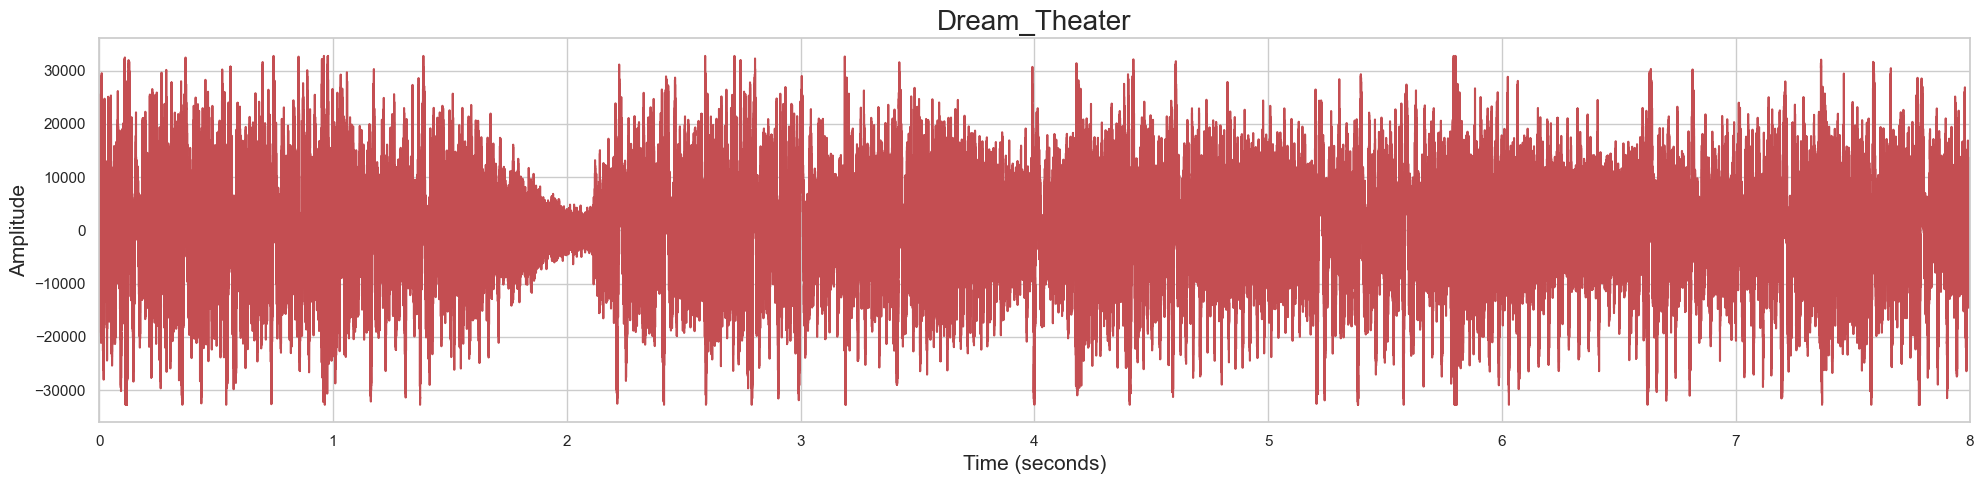

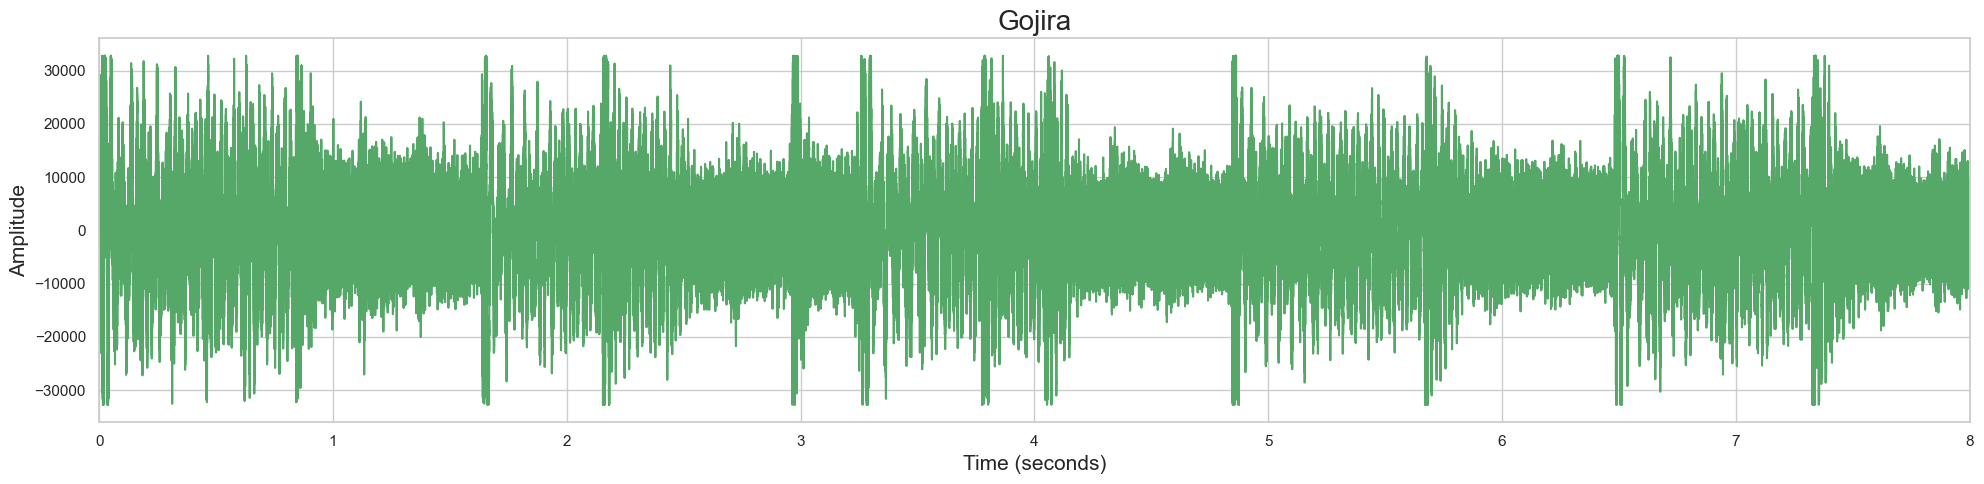

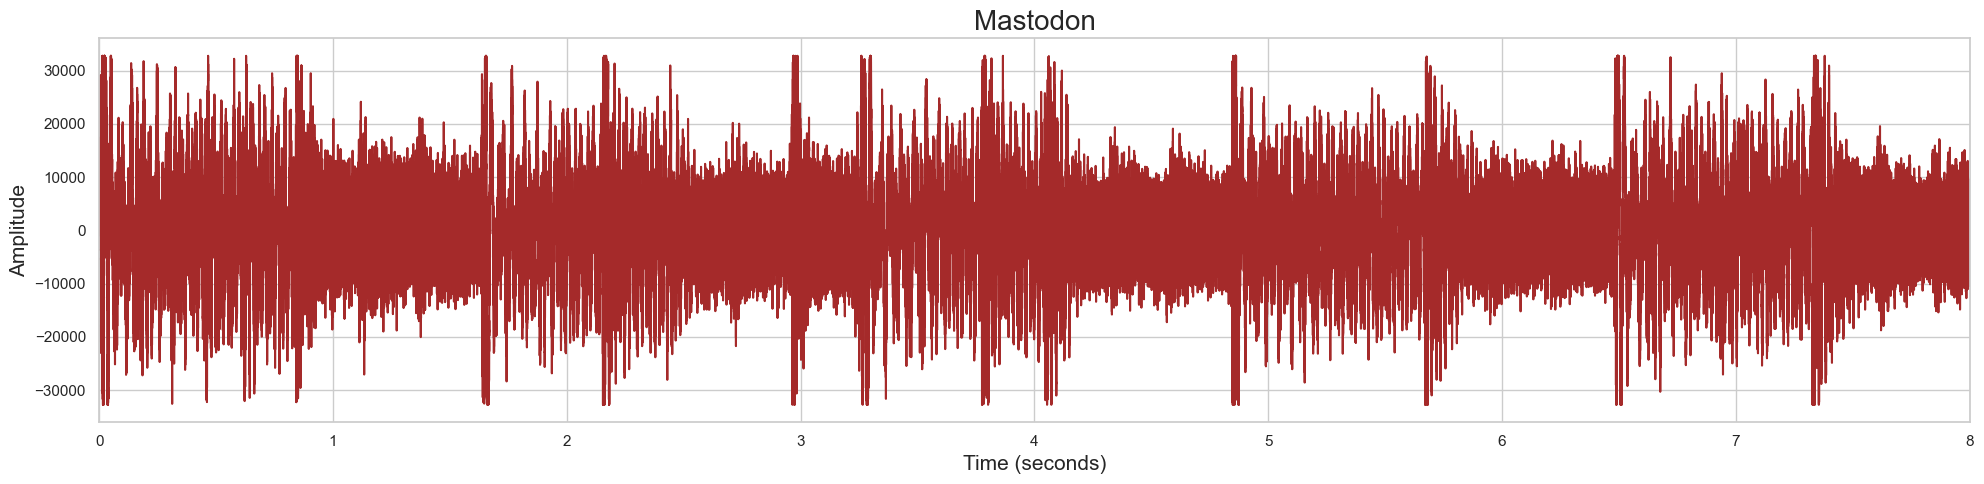

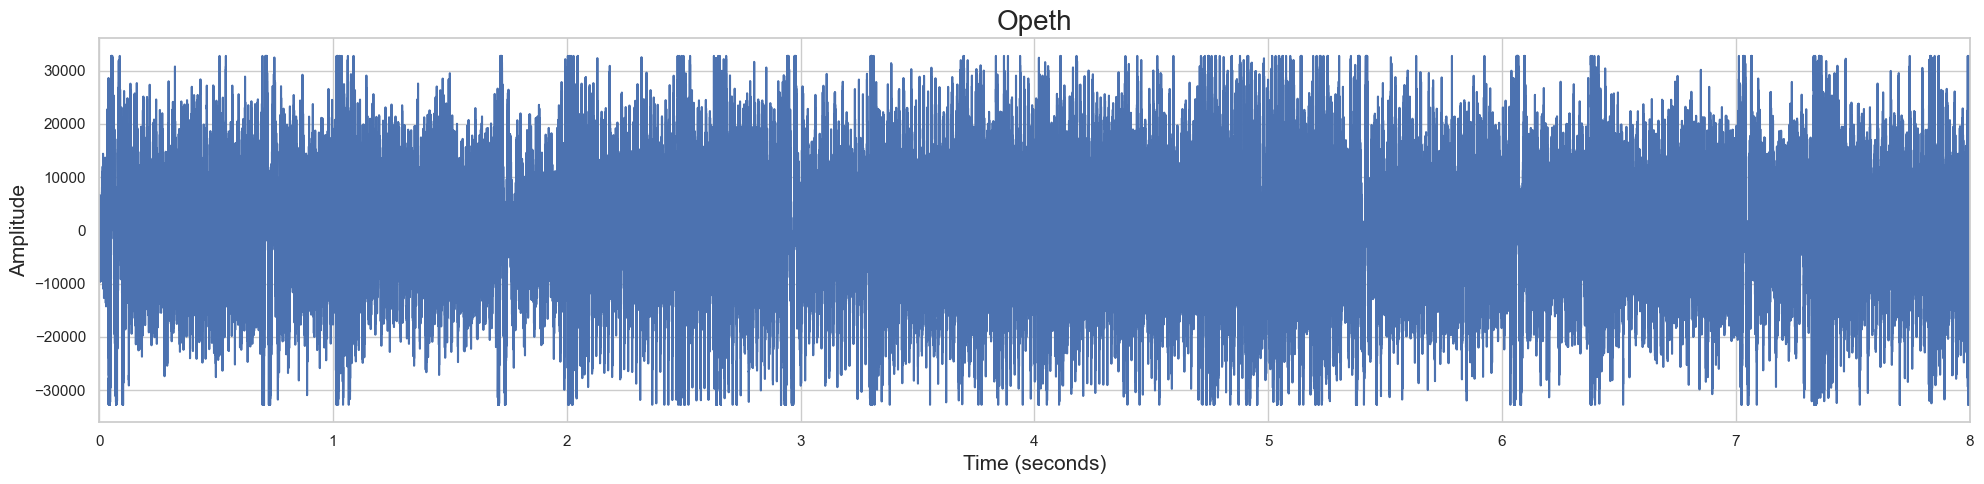

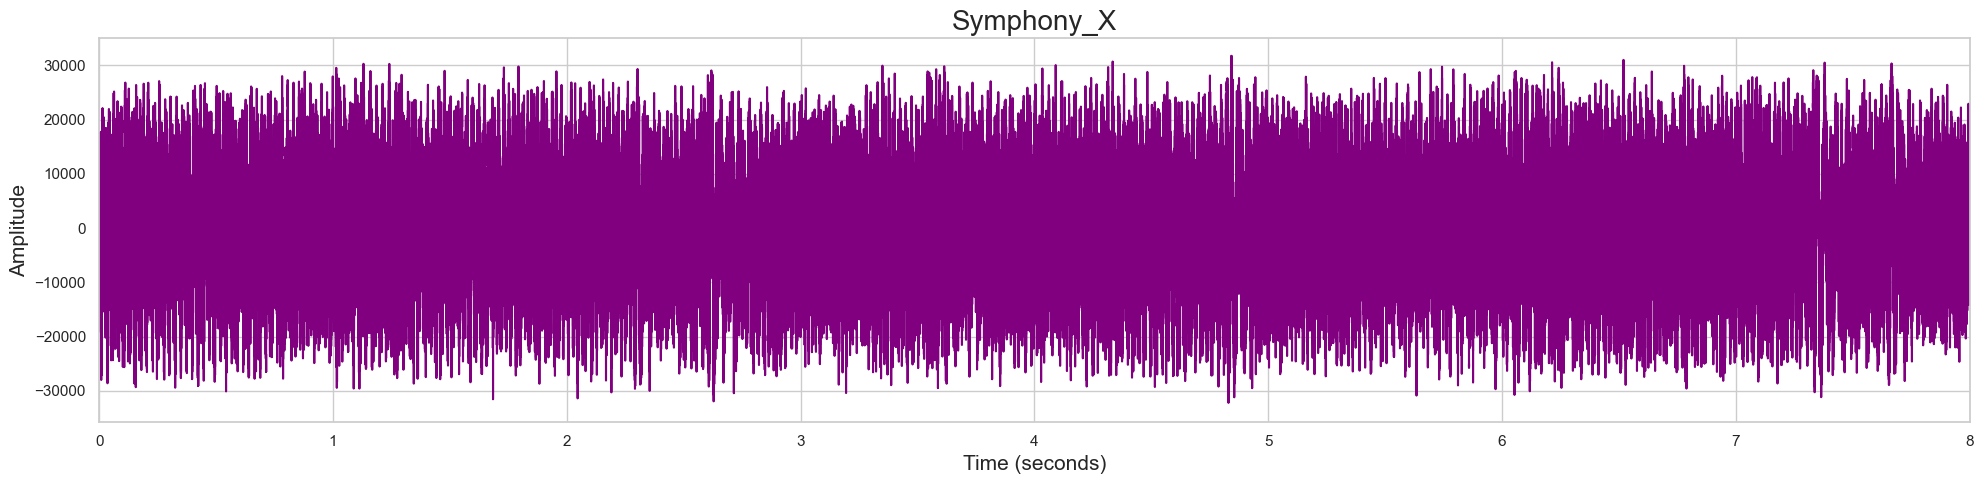

In [8]:
sns.set_theme(style="whitegrid")
def plot_wav(wav, band_name, color):
    audio_file = wave.open(wav, 'rb')
    frame_rate = audio_file.getframerate()
    signal = np.frombuffer(audio_file.readframes(-1), dtype=np.int16)
    # Time array for the x axis
    time = np.linspace(0, len(signal) / frame_rate, num=len(signal))
    plt.figure(figsize=(20, 5))
    plt.plot(time, signal, color=color)
    plt.title(band_name,fontsize=20)
    plt.xlabel('Time (seconds)',fontsize=15)
    plt.ylabel('Amplitude',fontsize=15)
    plt.xlim(0, duration)
    plt.tight_layout()
    plt.show()

band_0 = riff_list[0]
band_1 = riff_list[52]
band_2 = riff_list[101]
band_3 = riff_list[151]
band_4 = riff_list[201]

plot_wav(band_0,'Dream_Theater',color='r')
plot_wav(band_1,'Gojira',color='g')
plot_wav(band_1,'Mastodon',color='brown')
plot_wav(band_2,'Opeth',color='b')
plot_wav(band_3,'Symphony_X',color='purple')

In [9]:
feature_matrix = []
# Equal signal rate = 22050 for all songs
sr = 22050
print("Featurizing the riffs...")
for y in tqdm(trimmed_y):
    feature_vector = []
    # Setting frame size to 60ms and a frame step of 30ms (50% overlap)
    feats, names = sF.feature_extraction(y ,sr, 0.06*sr, 0.03*sr,deltas=True)
    feats_mean = np.mean(feats,axis=1)
    feats_std = np.std(feats,axis=1)
    feature_vector.extend(feats_mean)
    feature_vector.extend(feats_std)
    feature_matrix.append(feature_vector)
names_mean = []
names_std = []
for name in names:
    names_mean.append(name+'_mean')
    names_std.append(name+'_std')
feature_names = names_mean + names_std
df_features = pd.DataFrame(feature_matrix, columns = feature_names)

Featurizing the riffs...


100%|██████████| 250/250 [01:10<00:00,  3.55it/s]


In [10]:
df_features.head()

,zcr_mean,energy_mean,energy_entropy_mean,spectral_centroid_mean,spectral_spread_mean,spectral_entropy_mean,spectral_flux_mean,spectral_rolloff_mean,mfcc_1_mean,mfcc_2_mean,...,delta chroma_4_std,delta chroma_5_std,delta chroma_6_std,delta chroma_7_std,delta chroma_8_std,delta chroma_9_std,delta chroma_10_std,delta chroma_11_std,delta chroma_12_std,delta chroma_std_std
0,0.106985,0.056662,2.968747,0.219301,0.238639,0.753701,0.003152,0.130780,-22.261568,1.927881,...,0.051266,0.007322,0.024065,0.009715,0.035740,0.003982,0.012644,0.030703,0.007032,0.010654
1,0.101330,0.052289,2.930866,0.220246,0.243892,0.664014,0.003145,0.105849,-22.271940,2.035895,...,0.044594,0.009106,0.028126,0.006674,0.053327,0.004550,0.013635,0.028950,0.003029,0.011569
2,0.119864,0.040477,3.085317,0.229242,0.234339,0.975852,0.002067,0.188873,-22.055852,1.751577,...,0.033552,0.007148,0.017827,0.008005,0.044016,0.004592,0.009247,0.021371,0.003470,0.009536
3,0.094208,0.057660,2.953604,0.214745,0.240197,0.614545,0.004044,0.117769,-23.417422,2.059743,...,0.035044,0.004489,0.018384,0.003767,0.043043,0.002104,0.015281,0.039167,0.001734,0.010562
4,0.101587,0.056157,3.009518,0.219192,0.233237,0.752060,0.002869,0.135980,-22.246336,1.882727,...,0.044268,0.004765,0.027220,0.004362,0.049654,0.006815,0.030727,0.023768,0.002897,0.011696


In [11]:
pd.set_option('display.max_columns', None)
print(f'Total features of the dataset = {len(df_features.columns)} \n')
print(df_features.columns)

Total features of the dataset = 136 

Index(['zcr_mean', 'energy_mean', 'energy_entropy_mean',
       'spectral_centroid_mean', 'spectral_spread_mean',
       'spectral_entropy_mean', 'spectral_flux_mean', 'spectral_rolloff_mean',
       'mfcc_1_mean', 'mfcc_2_mean',
       ...
       'delta chroma_4_std', 'delta chroma_5_std', 'delta chroma_6_std',
       'delta chroma_7_std', 'delta chroma_8_std', 'delta chroma_9_std',
       'delta chroma_10_std', 'delta chroma_11_std', 'delta chroma_12_std',
       'delta chroma_std_std'],
      dtype='object', length=136)


In [12]:
encoder = LabelEncoder()    
labels_encoded = encoder.fit_transform(label_list)
if 'Band' not in df_features.columns:
    df_features.insert(loc = 0, column = 'Band', 
        value = labels_encoded , allow_duplicates = True)
df_features.head()

,Band,zcr_mean,energy_mean,energy_entropy_mean,spectral_centroid_mean,spectral_spread_mean,spectral_entropy_mean,spectral_flux_mean,spectral_rolloff_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,mfcc_11_mean,mfcc_12_mean,mfcc_13_mean,chroma_1_mean,chroma_2_mean,chroma_3_mean,chroma_4_mean,chroma_5_mean,chroma_6_mean,chroma_7_mean,chroma_8_mean,chroma_9_mean,chroma_10_mean,chroma_11_mean,chroma_12_mean,chroma_std_mean,delta zcr_mean,delta energy_mean,delta energy_entropy_mean,delta spectral_centroid_mean,delta spectral_spread_mean,delta spectral_entropy_mean,delta spectral_flux_mean,delta spectral_rolloff_mean,delta mfcc_1_mean,delta mfcc_2_mean,delta mfcc_3_mean,delta mfcc_4_mean,delta mfcc_5_mean,delta mfcc_6_mean,delta mfcc_7_mean,delta mfcc_8_mean,delta mfcc_9_mean,delta mfcc_10_mean,delta mfcc_11_mean,delta mfcc_12_mean,delta mfcc_13_mean,delta chroma_1_mean,delta chroma_2_mean,delta chroma_3_mean,delta chroma_4_mean,delta chroma_5_mean,delta chroma_6_mean,delta chroma_7_mean,delta chroma_8_mean,delta chroma_9_mean,delta chroma_10_mean,delta chroma_11_mean,delta chroma_12_mean,delta chroma_std_mean,zcr_std,energy_std,energy_entropy_std,spectral_centroid_std,spectral_spread_std,spectral_entropy_std,spectral_flux_std,spectral_rolloff_std,mfcc_1_std,mfcc_2_std,mfcc_3_std,mfcc_4_std,mfcc_5_std,mfcc_6_std,mfcc_7_std,mfcc_8_std,mfcc_9_std,mfcc_10_std,mfcc_11_std,mfcc_12_std,mfcc_13_std,chroma_1_std,chroma_2_std,chroma_3_std,chroma_4_std,chroma_5_std,chroma_6_std,chroma_7_std,chroma_8_std,chroma_9_std,chroma_10_std,chroma_11_std,chroma_12_std,chroma_std_std,delta zcr_std,delta energy_std,delta energy_entropy_std,delta spectral_centroid_std,delta spectral_spread_std,delta spectral_entropy_std,delta spectral_flux_std,delta spectral_rolloff_std,delta mfcc_1_std,delta mfcc_2_std,delta mfcc_3_std,delta mfcc_4_std,delta mfcc_5_std,delta mfcc_6_std,delta mfcc_7_std,delta mfcc_8_std,delta mfcc_9_std,delta mfcc_10_std,delta mfcc_11_std,delta mfcc_12_std,delta mfcc_13_std,delta chroma_1_std,delta chroma_2_std,delta chroma_3_std,delta chroma_4_std,delta chroma_5_std,delta chroma_6_std,delta chroma_7_std,delta chroma_8_std,delta chroma_9_std,delta chroma_10_std,delta chroma_11_std,delta chroma_12_std,delta chroma_std_std
0,0,0.106985,0.056662,2.968747,0.219301,0.238639,0.753701,0.003152,0.130780,-22.261568,1.927881,0.690125,0.320983,0.261255,0.302622,-0.017394,0.035795,0.141565,0.141381,-0.041026,-0.081630,-0.118350,0.019556,0.041516,0.009932,0.074799,0.006358,0.031882,0.005676,0.054289,0.003484,0.011926,0.043147,0.005616,0.031019,0.000108,-0.000171,0.002205,0.000002,0.000006,0.000099,0.000020,0.000080,-0.001449,0.001745,-0.001482,-0.001531,-0.002595,-0.000900,-0.000751,0.000462,0.000436,0.000646,0.000671,-0.000545,-0.000233,0.000014,-0.000131,0.000183,0.000379,-1.468081e-06,-0.000047,-0.000002,-0.000158,0.000043,-2.574753e-04,-0.000160,-1.646119e-07,0.000013,0.060350,0.026072,0.213945,0.053762,0.024258,0.482033,0.001883,0.143731,1.111438,0.282278,0.214988,0.236948,0.268851,0.189335,0.208949,0.212927,0.245901,0.201290,0.173779,0.147243,0.158828,0.018896,0.027084,0.012754,0.049119,0.007575,0.032865,0.009226,0.037191,0.004256,0.011418,0.027077,0.006905,0.010575,0.032089,0.024050,0.258337,0.028752,0.014692,0.296204,0.002346,0.085103,0.609253,0.243844,0.193458,0.215928,0.223399,0.194643,0.193207,0.188876,0.200236,0.167627,0.182516,0.163327,0.154025,0.017262,0.028489,0.012229,0.051266,0.007322,0.024065,0.009715,0.035740,0.003982,0.012644,0.030703,0.007032,0.010654
1,0,0.101330,0.052289,2.930866,0.220246,0.243892,0.664014,0.003145,0.105849,-22.271940,2.035895,0.745711,0.215172,0.251003,0.293585,0.046215,-0.010423,0.021158,0.174189,-0.003647,-0.016986,-0.025291,0.009709,0.032355,0.010584,0.077766,0.008364,0.032119,0.005639,0.076117,0.004015,0.014530,0.051060,0.002571,0.033318,0.000114,0.000141,-0.001459,0.000235,0.000251,0.000403,0.000025,-0.000046,0.002309,-0.001863,0.

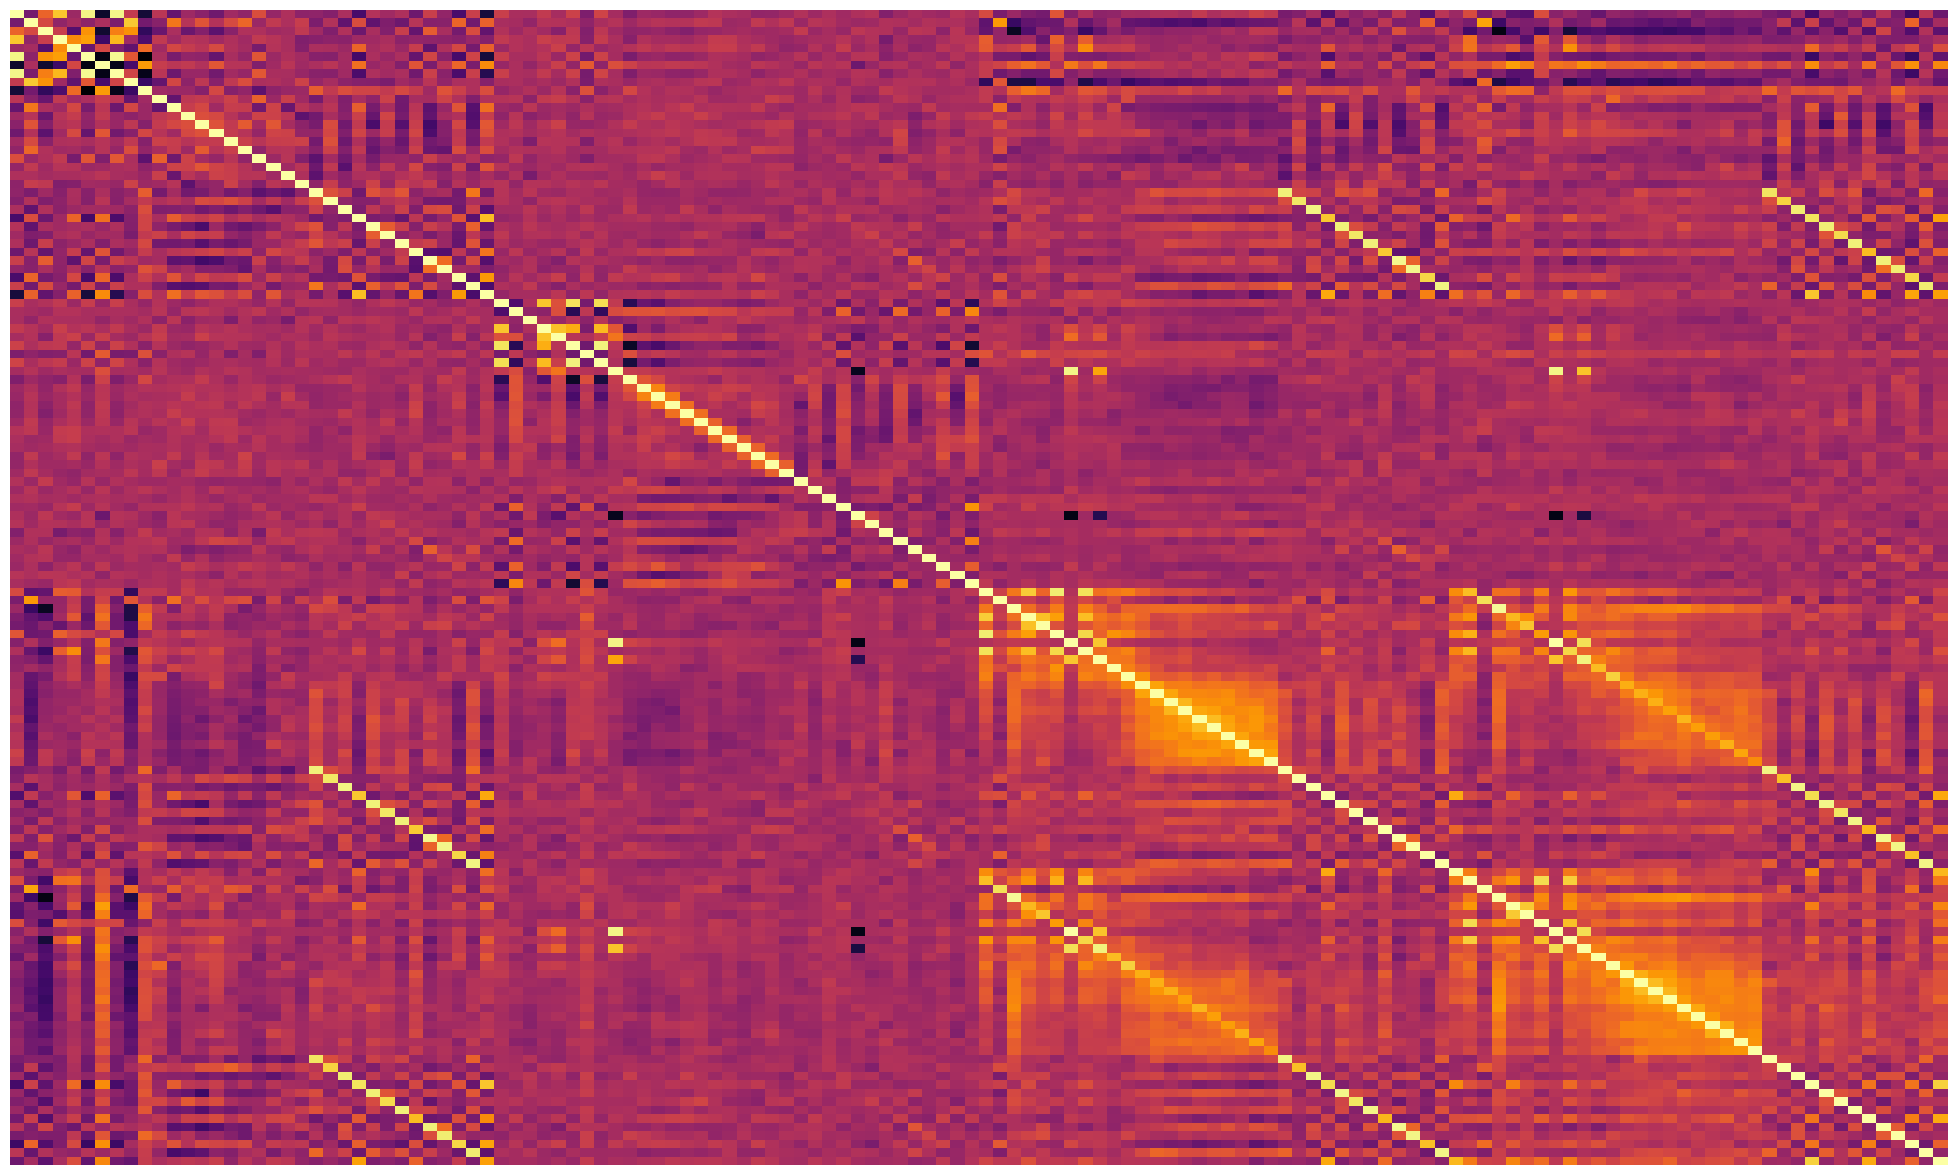

In [13]:
# Show the correlation matrix
plt.figure(figsize=(25, 15))
sns.heatmap(df_features.drop(['Band'],axis=1).corr(),
            annot=False, cbar=False, cmap='inferno', xticklabels=False, yticklabels=False)
plt.show()

In [14]:
threshold = 0.85
corr_matrix = df_features.corr('spearman').abs()  # Compute absolute values
# Check only upper_tri for efficiency. k = 1 is for upper diagonal
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
# Drop first feature from a pair of two
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
df_features = df_features.drop(to_drop, axis=1)
print(f"Features removed with corellation = {len(to_drop)} \n")

Features removed with corellation = 29 



In [92]:
def tuning_pipeline(model, parameter_grid, dataframe):
    cv = StratifiedShuffleSplit(n_splits=20, test_size=0.2, random_state=42)
    X = dataframe.drop('Band', axis=1)
    y = dataframe['Band']
    scaler = MinMaxScaler()
    clf = GridSearchCV(model, parameter_grid, scoring = 'f1_macro', cv = cv, verbose = 1)
    pipeline = Pipeline([('scaler', scaler), ('clf', clf)])
    pipeline.fit(X, y)
    best_score = clf.best_score_
    best_params = clf.best_params_
    best_index = clf.best_index_
    best_score_std = clf.cv_results_['std_test_score'][best_index]
    return best_params,  best_score, best_score_std

def tuning_with_dim_red(model, parameter_grid, dataframe, reductor = 'pca'):
    cv = StratifiedShuffleSplit(n_splits=20, test_size=0.2, random_state=42)
    X = dataframe.drop('Band', axis=1)
    y = dataframe['Band']
    scaler = MinMaxScaler()
    if reductor == 'pca':
        reductor = PCA()
    elif reductor == 'lda':
        reductor = LinearDiscriminantAnalysis()
    parameter_grid = {**parameter_grid, 'lda__n_components': list(range(1,10))}
    pipeline = Pipeline([
        ('scaler', scaler),
        ('lda', reductor),
        ('clf', model)
    ])
    clf = GridSearchCV(pipeline, parameter_grid, scoring='f1_macro', cv=cv, verbose=0)
    clf.fit(X, y)
    best_params = clf.best_params_
    best_score = clf.best_score_
    best_index = clf.best_index_
    best_score_std = clf.cv_results_['std_test_score'][best_index]
    return best_params,  best_score, best_score_std

In [107]:
def trainer(pipeline = 'default'):
    logging_dict = dict()
    # Logistic Regression
    model_lr = LogisticRegression(random_state=42, max_iter=1000)
    if pipeline.lower() == 'default':
        parameters_lr = {'C': [0.01, 0.1, 1, 10, 100]}
        best_logistic, best_f1_logistic, std_logistic = tuning_pipeline(model_lr, parameters_lr, df_features)
    elif pipeline.lower() == 'lda':
        parameters_lr = {'clf__C': [0.01, 0.1, 1, 10, 100]}
        best_logistic, best_f1_logistic, std_logistic = tuning_with_dim_red(model_lr, parameters_lr, df_features, reductor='lda')
    elif pipeline.lower() == 'pca':
        parameters_lr = {'clf__C': [0.01, 0.1, 1, 10, 100]}
        best_logistic, best_f1_logistic, std_logistic = tuning_with_dim_red(model_lr, parameters_lr, df_features, reductor='pca')
    print(f"Best Logistic Regression model: {best_logistic}")
    print(f"Best F1 score for Logistic Regression: {best_f1_logistic:.3f}({std_logistic:.3f}) \n")
    logging_dict['Logistic Regression'] = (best_logistic, best_f1_logistic, std_logistic)
    # KNN
    model_knn = KNeighborsClassifier()
    if pipeline.lower() == 'default':
        parameters_knn = {'n_neighbors': [3, 5, 7, 9, 11],
                    'p': [1, 2]}
        best_knn, best_f1_knn, std_knn = tuning_pipeline(model_knn, parameters_knn, df_features)
    elif pipeline.lower() == 'lda':
        parameters_knn = {'clf__n_neighbors': [3, 5, 7, 9, 11],
                    'clf__p': [1, 2]} 
        best_knn, best_f1_knn, std_knn = tuning_with_dim_red(model_knn, parameters_knn, df_features, reductor='lda')
    elif pipeline.lower() == 'pca':
        parameters_knn = {'clf__n_neighbors': [3, 5, 7, 9, 11],
                    'clf__p': [1, 2]} 
        best_knn, best_f1_knn, std_knn = tuning_with_dim_red(model_knn, parameters_knn, df_features, reductor='pca')
    print(f"Best KNN  model: {best_knn}")
    print(f"Best F1 score for KNN: {best_f1_knn:.3f}({std_knn:.3f}) \n")
    logging_dict['KNN'] = (best_knn, best_f1_knn, std_knn)
    # SVM
    model_svm = SVC(random_state=42, probability=True)
    if pipeline.lower() == 'default':
        parameters_svm = {'C': [0.01, 0.1, 1, 10],
                    'kernel': ['linear', 'rbf']}
        best_svm, best_f1_svm, std_svm = tuning_pipeline(model_svm, parameters_svm, df_features)
    elif pipeline.lower() == 'lda':
        parameters_svm = {'clf__C': [0.01, 0.1, 1, 10],
                    'clf__kernel': ['linear', 'rbf']}
        best_svm, best_f1_svm, std_svm = tuning_with_dim_red(model_svm, parameters_svm, df_features, reductor='lda')
    elif pipeline.lower() == 'pca':
        parameters_svm = {'clf__C': [0.01, 0.1, 1, 10],
                    'clf__kernel': ['linear', 'rbf']}
        best_svm, best_f1_svm, std_svm = tuning_with_dim_red(model_svm, parameters_svm, df_features, reductor='pca')
    print(f"Best SVM model: {best_svm}")
    print(f"Best F1 score for SVM: {best_f1_svm:.3f}({std_svm:.3f}) \n")
    logging_dict['SVM'] = (best_svm, best_f1_svm, std_svm)
    return logging_dict

In [110]:
print("-----Modelling without dimensionality reduction----- \n")
default_dict = trainer(pipeline='default')

-----Modelling without dimensionality reduction----- 

Fitting 20 folds for each of 5 candidates, totalling 100 fits
Best Logistic Regression model: {'C': 1}
Best F1 score for Logistic Regression: 0.738(0.067) 

Fitting 20 folds for each of 10 candidates, totalling 200 fits
Best KNN  model: {'n_neighbors': 7, 'p': 1}
Best F1 score for KNN: 0.707(0.047) 

Fitting 20 folds for each of 8 candidates, totalling 160 fits
Best SVM model: {'C': 10, 'kernel': 'rbf'}
Best F1 score for SVM: 0.774(0.052) 



In [111]:
print("-----Modelling with LDA----- \n")
lda_dict = trainer(pipeline='lda')

-----Modelling with LDA----- 



In [ ]:
print("-----Modelling with PCA----- \n")
pca_dict = trainer(pipeline='pca')